# Homework 1:

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images.  It did ... OK.  There is significant overfitting of this model.  There are some ways to address that, but we didn't have time to get into that in this session.

Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture.  Change one or more of the following:
- The number of convolutions between downsampling
- The number of filters in each layer
- The initial "patchify" layer
- Another hyper-parameter of your choosing


And compare your final validation accuracy to the accuracy shown here.  Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train.  You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.

In [1]:
import torch, torchvision
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm


# Building a ConvNet

In this section we'll build and apply a conv net to the mnist dataset.  The layers here are loosely based off of the ConvNext architecture.  Why?  Because we're getting into LLM's soon, and this ConvNet uses LLM features.  ConvNext is an update to the ResNet architecture that outperforms it.

[ConvNext](https://arxiv.org/abs/2201.03545)


The dataset here is CIFAR-10 - slightly harder than MNIST but still relatively easy and computationally tractable.

In [2]:
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=True,
    download=False,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=False,
    download=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=4)
val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=4)

/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

This code below is important as our models get bigger: this is wrapping the pytorch data loaders to put the data onto the GPU!

In [3]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [4]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):


        return self.downsample(self.norm(inputs))
        
        

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape, dropout = 0.2):
        super(ConvNextBlock, self).__init__()
        
        # dropout rate
        self.dropout = dropout

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)
        self.dropout1 = nn.Dropout2d(p=dropout)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )
        self.dropout2 = nn.Dropout2d(p=dropout)


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)
        
        x = self.dropout1(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)
        
        x = self.dropout2(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [5]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()
            
    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss

In [6]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()      

        progress_bar.update()

In [7]:
model = Classifier(128, 2, 3)

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 128, 32, 32]        512
├─LayerNorm: 1-2                         [128, 128, 32, 32]        262,144
├─Sequential: 1-3                        [128, 256, 16, 16]        --
│    └─ConvNextBlock: 2-1                [128, 128, 32, 32]        --
│    │    └─Conv2d: 3-1                  [128, 128, 32, 32]        6,400
│    │    └─LayerNorm: 3-2               [128, 128, 32, 32]        262,144
│    │    └─Conv2d: 3-3                  [128, 512, 32, 32]        66,048
│    │    └─Dropout2d: 3-4               [128, 512, 32, 32]        --
│    │    └─Conv2d: 3-5                  [128, 128, 32, 32]        65,664
│    │    └─Dropout2d: 3-6               [128, 128, 32, 32]        --
│    └─ConvNextBlock: 2-2                [128, 128, 32, 32]        --
│    │    └─Conv2d: 3-7                  [128, 128, 32, 32]    

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.005)

In [9]:
train_his = {'acc':[], 'loss':[]}
val_his = {'acc':[], 'loss':[]}

epochs = 50
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)
    
    # checking on the training loss and accuracy once per epoch
        
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
        train_his['acc'].append(acc)
        train_his['loss'].append(loss)

        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        val_his['acc'].append(acc_val)
        val_his['loss'].append(loss_val)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.644, accuracy: 40.677


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.611, accuracy: 41.001


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 1.358, accuracy: 51.403


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.345, accuracy: 51.197


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 1.124, accuracy: 60.593


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.136, accuracy: 59.395


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 0.930, accuracy: 67.327


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 0.971, accuracy: 65.724


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 0.740, accuracy: 74.436


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 0.794, accuracy: 72.142


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.667, accuracy: 76.879


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.734, accuracy: 74.199


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.582, accuracy: 80.022


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.655, accuracy: 77.057


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.512, accuracy: 82.184


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.612, accuracy: 78.293


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.496, accuracy: 82.553


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.619, accuracy: 79.025


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.436, accuracy: 84.630


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.556, accuracy: 80.795


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.389, accuracy: 86.552


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.523, accuracy: 82.298


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.389, accuracy: 86.220


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.527, accuracy: 81.626


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.346, accuracy: 87.807


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.512, accuracy: 82.209


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.279, accuracy: 90.098


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.459, accuracy: 83.999


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.306, accuracy: 89.330


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.492, accuracy: 83.169


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.258, accuracy: 90.795


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.474, accuracy: 83.732


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.224, accuracy: 92.155


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.445, accuracy: 85.057


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.210, accuracy: 92.480


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.432, accuracy: 85.374


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.228, accuracy: 91.841


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.471, accuracy: 84.929


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.168, accuracy: 93.975


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.405, accuracy: 86.165


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 0.174, accuracy: 93.815


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.438, accuracy: 86.007


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21: training loss: 0.161, accuracy: 94.192


Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.436, accuracy: 86.076


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22: training loss: 0.159, accuracy: 94.187


Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.441, accuracy: 85.858


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23: training loss: 0.159, accuracy: 94.339


Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.456, accuracy: 85.552


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24: training loss: 0.116, accuracy: 95.764


Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.425, accuracy: 86.788


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 0.129, accuracy: 95.285


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.429, accuracy: 86.501


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26: training loss: 0.110, accuracy: 96.059


Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.410, accuracy: 87.144


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27: training loss: 0.116, accuracy: 95.802


Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.440, accuracy: 87.025


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28: training loss: 0.116, accuracy: 95.679


Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.426, accuracy: 86.946


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29: training loss: 0.090, accuracy: 96.640


Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.414, accuracy: 87.144


Train Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30: training loss: 0.083, accuracy: 96.970


Validate Epoch 30:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30: validation loss: 0.424, accuracy: 87.055


Train Epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 31: training loss: 0.086, accuracy: 96.880


Validate Epoch 31:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31: validation loss: 0.428, accuracy: 87.134


Train Epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 32: training loss: 0.095, accuracy: 96.421


Validate Epoch 32:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32: validation loss: 0.443, accuracy: 86.620


Train Epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 33: training loss: 0.075, accuracy: 97.354


Validate Epoch 33:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33: validation loss: 0.418, accuracy: 87.579


Train Epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 34: training loss: 0.070, accuracy: 97.399


Validate Epoch 34:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34: validation loss: 0.422, accuracy: 87.668


Train Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35: training loss: 0.072, accuracy: 97.324


Validate Epoch 35:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35: validation loss: 0.426, accuracy: 87.856


Train Epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 36: training loss: 0.065, accuracy: 97.489


Validate Epoch 36:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36: validation loss: 0.434, accuracy: 87.164


Train Epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 37: training loss: 0.078, accuracy: 96.957


Validate Epoch 37:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37: validation loss: 0.461, accuracy: 87.134


Train Epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 38: training loss: 0.068, accuracy: 97.494


Validate Epoch 38:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38: validation loss: 0.439, accuracy: 87.737


Train Epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 39: training loss: 0.067, accuracy: 97.516


Validate Epoch 39:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39: validation loss: 0.465, accuracy: 87.401


Train Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40: training loss: 0.063, accuracy: 97.711


Validate Epoch 40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40: validation loss: 0.451, accuracy: 87.886


Train Epoch 41:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 41:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 41: training loss: 0.063, accuracy: 97.581


Validate Epoch 41:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41: validation loss: 0.472, accuracy: 87.302


Train Epoch 42:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 42:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 42: training loss: 0.056, accuracy: 97.873


Validate Epoch 42:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42: validation loss: 0.457, accuracy: 88.083


Train Epoch 43:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 43:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 43: training loss: 0.048, accuracy: 98.195


Validate Epoch 43:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43: validation loss: 0.420, accuracy: 88.123


Train Epoch 44:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 44:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 44: training loss: 0.046, accuracy: 98.300


Validate Epoch 44:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44: validation loss: 0.428, accuracy: 87.925


Train Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 45: training loss: 0.053, accuracy: 97.973


Validate Epoch 45:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45: validation loss: 0.462, accuracy: 87.737


Train Epoch 46:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 46:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 46: training loss: 0.054, accuracy: 97.941


Validate Epoch 46:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46: validation loss: 0.446, accuracy: 88.163


Train Epoch 47:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 47:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 47: training loss: 0.044, accuracy: 98.330


Validate Epoch 47:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47: validation loss: 0.449, accuracy: 88.271


Train Epoch 48:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 48:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 48: training loss: 0.042, accuracy: 98.413


Validate Epoch 48:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48: validation loss: 0.426, accuracy: 88.706


Train Epoch 49:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 49:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 49: training loss: 0.049, accuracy: 98.188


Validate Epoch 49:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49: validation loss: 0.451, accuracy: 88.014


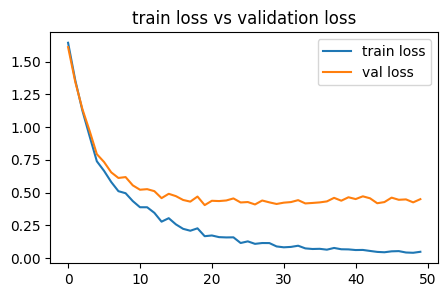

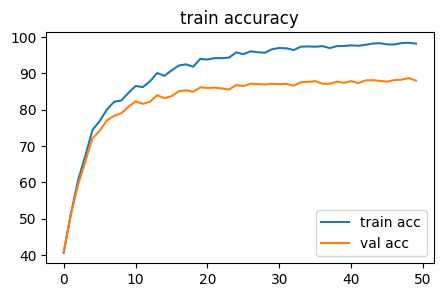

In [13]:
plt.figure(figsize=(5,3))
plt.plot(train_his['loss'],label='train loss')
plt.plot(val_his['loss'],label='val loss')
plt.legend()
plt.title('train loss vs validation loss')

plt.figure(figsize=(5,3))
plt.plot(train_his['acc'],label='train acc')
plt.plot(val_his['acc'],label='val acc')
plt.legend()
plt.title('train accuracy');

The model structure is adjusted with 128 filters, 2 stages and 3 residual blocks per stage.
Increasing the number of filters will allow a convolutional layer learn more features at a convlution process.
Reducing the number of stages will make the model less complex to address the overfitting.
Increasing the number of blocks in each stage also captures more features and relations that could improve the generalization ability.